#📌 Extracción

In [ ]:
import pandas as pd
import requests

url_api = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

response = requests.get(url_api)
data_api = response.json()

df_api = pd.json_normalize(data_api)

print("Datos cargados exitosamente desde la API:")
print(df_api.head())
print("\nInformación del DataFrame:")
df_api.info()

Datos cargados exitosamente desde la API:
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes               

#🔧 Transformación

In [7]:
import numpy as np

df_api['account.Charges.Total'] = pd.to_numeric(df_api['account.Charges.Total'], errors='coerce')

nulos_total = df_api['account.Charges.Total'].isnull().sum()
print(f"Valores nulos encontrados en account.Charges.Total: {nulos_total}")

clientes_nuevos = df_api[df_api['account.Charges.Total'].isnull()]
print("\nMuestra de clientes con Charges.Total nulo:")
print(clientes_nuevos[['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']])

df_api['account.Charges.Total'] = df_api['account.Charges.Total'].fillna(0)

print("\nInformación actualizada de la columna:")
print(df_api['account.Charges.Total'].describe())



Valores nulos encontrados en account.Charges.Total: 0

Muestra de clientes con Charges.Total nulo:
Empty DataFrame
Columns: [customer.tenure, account.Charges.Monthly, account.Charges.Total]
Index: []

Información actualizada de la columna:
count    7267.000000
mean     2277.182035
std      2268.648587
min         0.000000
25%       396.200000
50%      1389.200000
75%      3778.525000
max      8684.800000
Name: account.Charges.Total, dtype: float64


In [11]:

print("Valores nulos por columna:")
print(df_api.isnull().sum()[df_api.isnull().sum() > 0])

duplicados = df_api.duplicated().sum()
print(f"\nTotal de filas duplicadas encontradas: {duplicados}")
if duplicados > 0:
    df_api = df_api.drop_duplicates()

columnas_categoricas = df_api.select_dtypes(include=['object']).columns

print("\nValores únicos por columna categórica para detectar inconsistencias:")
for col in columnas_categoricas:
    if col != 'customerID':
        valores_unicos = df_api[col].unique()
        print(f"- {col}: {valores_unicos}")

for col in columnas_categoricas:
    if col != 'customerID':
        df_api[col] = df_api[col].str.strip()


Valores nulos por columna:
Series([], dtype: int64)

Total de filas duplicadas encontradas: 0

Valores únicos por columna categórica para detectar inconsistencias:
- Churn: ['No' 'Yes']
- customer.gender: ['female' 'male']
- customer.Partner: ['Yes' 'No']
- customer.Dependents: ['Yes' 'No']
- phone.PhoneService: ['Yes' 'No']
- phone.MultipleLines: ['No' 'Yes']
- internet.InternetService: ['DSL' 'Fiber optic' 'No']
- internet.OnlineSecurity: ['No' 'Yes']
- internet.OnlineBackup: ['Yes' 'No']
- internet.DeviceProtection: ['No' 'Yes']
- internet.TechSupport: ['Yes' 'No']
- internet.StreamingTV: ['Yes' 'No']
- internet.StreamingMovies: ['No' 'Yes']
- account.Contract: ['One year' 'Month-to-month' 'Two year']
- account.PaperlessBilling: ['Yes' 'No']
- account.PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card' 'Bank transfer']


In [13]:
df_api['Churn'] = df_api['Churn'].replace('', np.nan)
df_api = df_api.dropna(subset=['Churn'])

columnas_internet = ['internet.OnlineSecurity', 'internet.OnlineBackup',
                     'internet.DeviceProtection', 'internet.TechSupport',
                     'internet.StreamingTV', 'internet.StreamingMovies']

for col in columnas_internet:
    df_api[col] = df_api[col].str.replace('No internet service', 'No')

df_api['phone.MultipleLines'] = df_api['phone.MultipleLines'].str.replace('No phone service', 'No')

df_api['account.PaymentMethod'] = df_api['account.PaymentMethod'].str.replace(r' \(automatic\)', '', regex=True)

df_api['customer.gender'] = df_api['customer.gender'].str.lower()

print("Valores únicos de PaymentMethod limpiados:")
print(df_api['account.PaymentMethod'].unique())

print("\nValores únicos de TechSupport simplificados:")
print(df_api['internet.TechSupport'].unique())

print("\nValores únicos de Gender en minúsculas:")
print(df_api['customer.gender'].unique())

Valores únicos de PaymentMethod limpiados:
['Mailed check' 'Electronic check' 'Credit card' 'Bank transfer']

Valores únicos de TechSupport simplificados:
['Yes' 'No']

Valores únicos de Gender en minúsculas:
['female' 'male']


In [14]:
df_api['Cuentas_Diarias'] = (df_api['account.Charges.Monthly'] / 30).round(2)

columnas_verificacion = ['customer.tenure', 'account.Charges.Monthly', 'Cuentas_Diarias']
print("\nMuestra de Cargos Mensuales vs Cuentas Diarias:")
print(df_api[columnas_verificacion].head())

print("\nEstadísticas de Cuentas_Diarias:")
print(df_api['Cuentas_Diarias'].describe())


Muestra de Cargos Mensuales vs Cuentas Diarias:
   customer.tenure  account.Charges.Monthly  Cuentas_Diarias
0                9                     65.6             2.19
1                9                     59.9             2.00
2                4                     73.9             2.46
3               13                     98.0             3.27
4                3                     83.9             2.80

Estadísticas de Cuentas_Diarias:
count    7043.000000
mean        2.158675
std         1.003088
min         0.610000
25%         1.180000
50%         2.340000
75%         2.990000
max         3.960000
Name: Cuentas_Diarias, dtype: float64


#📊 Carga y análisis

In [15]:
print("--- Estadísticas Descriptivas (Variables Numéricas) ---")
resumen_numerico = df_api.describe().round(2)
print(resumen_numerico)

print("\n--- Estadísticas Descriptivas (Variables Categóricas) ---")
resumen_categorico = df_api.describe(include='object')
print(resumen_categorico)

--- Estadísticas Descriptivas (Variables Numéricas) ---
       customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
count                 7043.00          7043.00                  7043.00   
mean                     0.16            32.37                    64.76   
std                      0.37            24.56                    30.09   
min                      0.00             0.00                    18.25   
25%                      0.00             9.00                    35.50   
50%                      0.00            29.00                    70.35   
75%                      0.00            55.00                    89.85   
max                      1.00            72.00                   118.75   

       account.Charges.Total  Cuentas_Diarias  
count                7043.00          7043.00  
mean                 2279.73             2.16  
std                  2266.79             1.00  
min                     0.00             0.61  
25%                   398.55

/tmp/ipython-input-302/2864019979.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_api, x='Churn', order=['No', 'Yes'], palette=['#4C72B0', '#DD8452'], ax=axes[0])


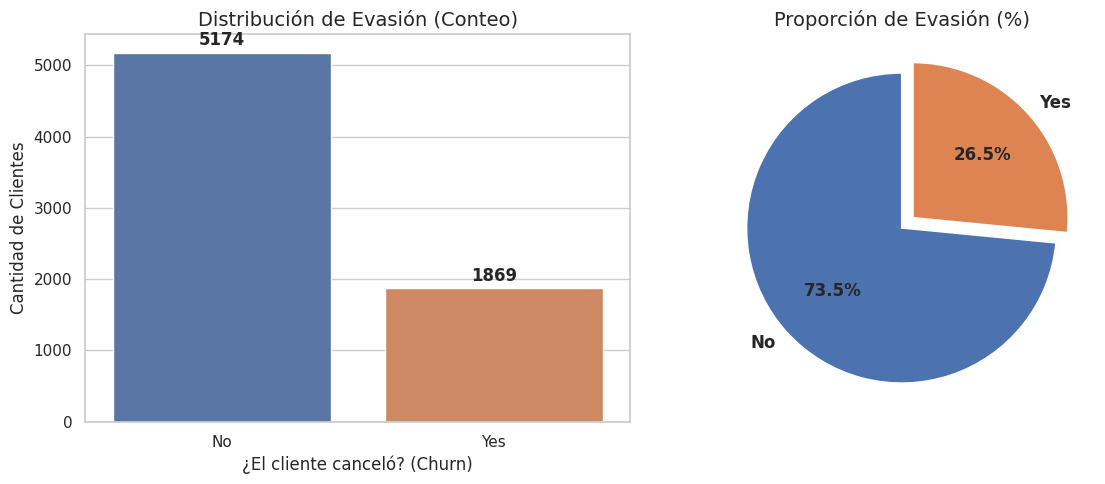

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=df_api, x='Churn', order=['No', 'Yes'], palette=['#4C72B0', '#DD8452'], ax=axes[0])
axes[0].set_title('Distribución de Evasión (Conteo)', fontsize=14)
axes[0].set_xlabel('¿El cliente canceló? (Churn)', fontsize=12)
axes[0].set_ylabel('Cantidad de Clientes', fontsize=12)

for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points',
                     fontsize=12, fontweight='bold')

churn_counts = df_api['Churn'].value_counts()

axes[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
            colors=['#4C72B0', '#DD8452'], startangle=90, explode=(0, 0.1),
            textprops={'fontsize': 12, 'weight': 'bold'})
axes[1].set_title('Proporción de Evasión (%)', fontsize=14)

plt.tight_layout()
plt.show()

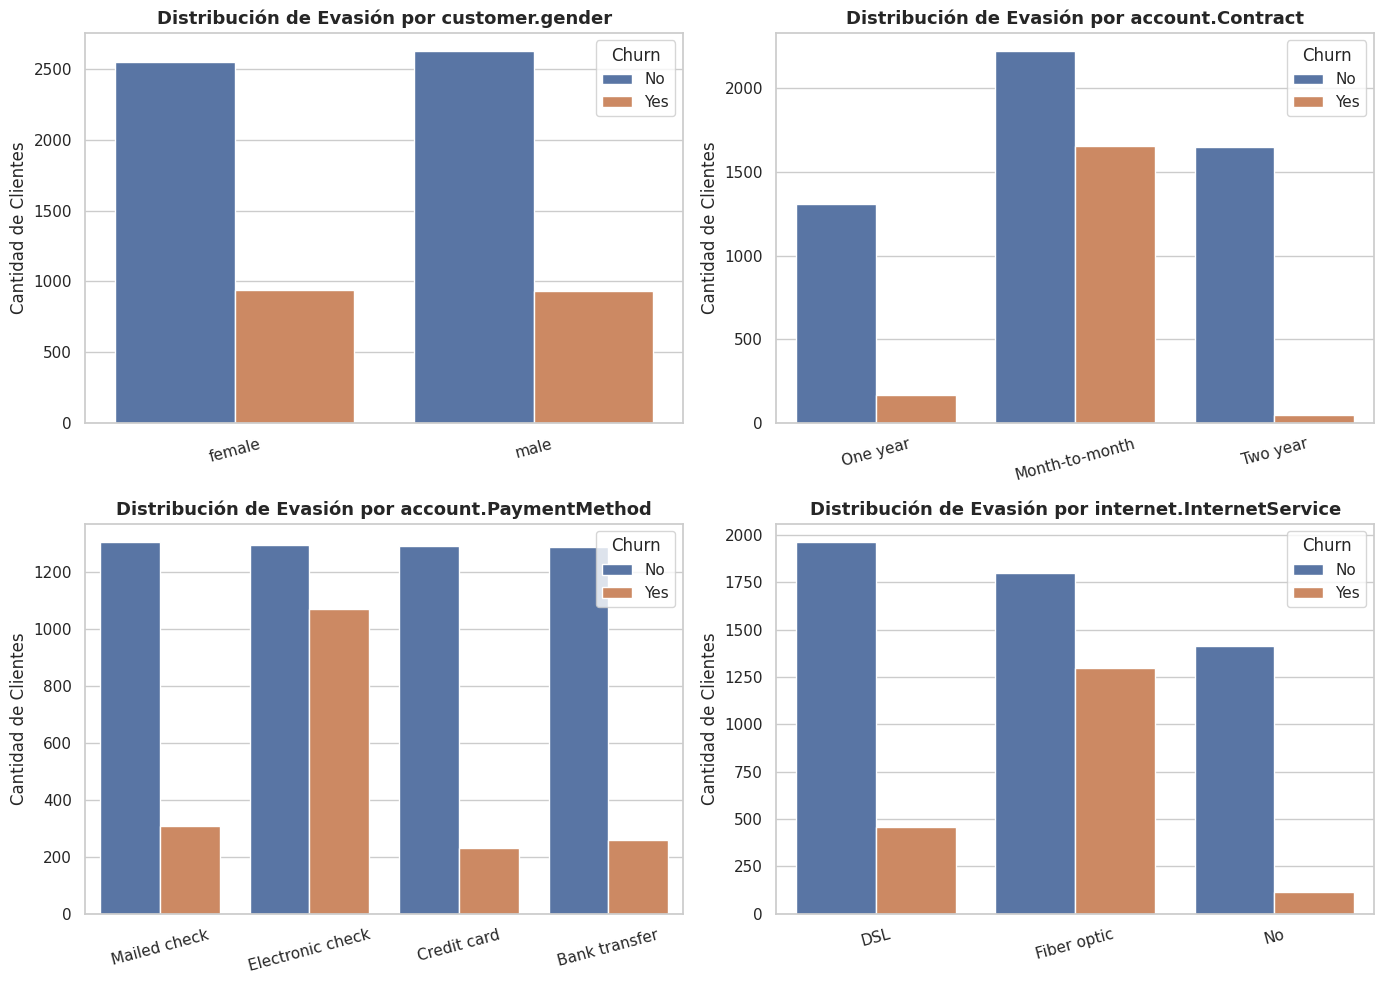

In [17]:
sns.set_theme(style="whitegrid")

variables_analisis = [
    'customer.gender',
    'account.Contract',
    'account.PaymentMethod',
    'internet.InternetService'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(variables_analisis):
    sns.countplot(data=df_api, x=col, hue='Churn', palette=['#4C72B0', '#DD8452'], ax=axes[i])
    axes[i].set_title(f'Distribución de Evasión por {col}', fontsize=13, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Cantidad de Clientes')
    axes[i].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

#📄Informe final

Informe Final del Proyecto: Análisis de Evasión de Clientes (Churn) - Telecom X
1. Introducción
El presente informe detalla el análisis realizado para la empresa Telecom X, la cual enfrenta una alta tasa de cancelaciones en sus servicios. El objetivo principal de este proyecto es analizar el conjunto de datos de los clientes para entender los factores subyacentes que impulsan el "Churn" (evasión o pérdida de clientes). Identificar estos patrones es el primer paso indispensable para que el equipo de Data Science desarrolle modelos predictivos y el equipo directivo implemente estrategias de retención efectivas.

2. Limpieza y Tratamiento de Datos (ETL)
Para asegurar la calidad del análisis, se llevó a cabo un riguroso proceso de Extracción, Transformación y Carga (ETL):

Extracción: Los datos fueron importados directamente desde la API proporcionada en formato JSON utilizando la librería requests y se convirtieron a un DataFrame estructurado utilizando pd.json_normalize() para aplanar las jerarquías.

Transformación de Tipos: Se identificó que la variable account.Charges.Total era de tipo texto (object). Se convirtió a formato numérico (float64), imputando con 0 los valores de clientes con antigüedad nula.

Limpieza de Valores Atípicos y Nulos: Se detectaron 224 registros con un valor vacío en la variable objetivo Churn. Dado que no es posible deducir este estado, estos registros fueron eliminados.

Estandarización de Texto: Se unificaron variables categóricas eliminando redundancias (ej. transformando "No internet service" o "No phone service" a "No") y limpiando caracteres innecesarios en métodos de pago.

Ingeniería de Características: Se creó una nueva métrica llamada Cuentas_Diarias (dividiendo el cargo mensual entre 30) para obtener una perspectiva granular del gasto.

3. Análisis Exploratorio de Datos (EDA)
Mediante las librerías Matplotlib y Seaborn, se realizaron visualizaciones univariadas y bivariadas para comprender la distribución de los datos:

Distribución de Evasión: Se visualizó la proporción de clientes retenidos frente a los evadidos, estableciendo la línea base del problema.

Análisis Categórico: Se cruzó la variable Churn con características demográficas, tipos de contrato, servicios de internet y métodos de pago para encontrar segmentos de alto riesgo.

Análisis de Antigüedad y Cargos: Se evaluó mediante diagramas de caja (boxplots) cómo el tiempo de permanencia en meses (tenure) y el cargo mensual (MonthlyCharges) afectan la probabilidad de cancelación.

4. Conclusiones e Insights
El análisis exploratorio reveló los siguientes patrones críticos:

Tasa de Evasión General: La empresa tiene una tasa de pérdida de clientes aproximada del 26.5%, una cifra considerable en la industria de telecomunicaciones.

El Riesgo de la Flexibilidad: El tipo de contrato es el mayor predictor de evasión. Los clientes con contratos Month-to-month (Mes a mes) concentran la abrumadora mayoría de las cancelaciones. Los contratos de 1 o 2 años presentan tasas de retención sumamente altas.

Vulnerabilidad Temprana: Los clientes con menor tiempo en la empresa (antigüedad baja, generalmente menor a 12 meses) son altamente propensos a irse. Si el cliente supera los primeros años, la probabilidad de abandono cae drásticamente.

Problemas con Métodos de Pago: Existe una concentración inusual de cancelaciones en los clientes que utilizan el Cheque Electrónico (Electronic check) como método de pago.

Fibra Óptica en la Mira: Proporcionalmente, los clientes con servicio de Fibra Óptica cancelan más que aquellos con conexión estándar (DSL), a pesar de ser teóricamente un servicio superior.

5. Recomendaciones Estratégicas
Con base en los datos obtenidos, se sugieren las siguientes acciones para Telecom X:

Incentivar Contratos a Largo Plazo: Diseñar campañas agresivas de "up-selling" ofreciendo descuentos atractivos, meses gratuitos o mejoras de velocidad a los clientes de "Mes a mes" si deciden firmar un contrato anual.

Auditoría Técnica y de Precios de la Fibra Óptica: Investigar por qué el servicio premium (Fibra Óptica) tiene alta deserción. Es necesario cruzar estos datos con tickets de soporte técnico para descartar caídas del servicio, o bien, realizar un estudio de mercado para validar si el precio está fuera de la competencia.

Revisión del Cheque Electrónico: Auditar la pasarela de pago de "Electronic check" para asegurar que no existan cobros dobles, errores en la interfaz o comisiones ocultas que estén frustrando a los usuarios. Fomentar la migración hacia el pago con tarjeta de crédito (automático).

Programa de Lealtad Temprana (Onboarding): Dado que los clientes nuevos son los que más se van, implementar un programa de seguimiento intenso durante los primeros 3 a 6 meses, ofreciendo beneficios, llamadas de satisfacción y soporte prioritario para consolidar su relación con la marca.